# Week6. Homework.

## Author George Chizhmak (23.10.2023).

Dataset
In this homework, we will use the California Housing Prices from Kaggle.

Here's a wget-able link:

wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').

## Preparing the dataset
For this homework, we only want to use a subset of data. This is the same subset we used in homework #2. But in contrast to homework #2, we are going to use all columns of the dataset.

First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

Preparation:

- Fill missing values with zeros.
- Apply the log transform to median_house_value.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.
- Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [3]:
import pandas as pd
import numpy as np

In [6]:
data = pd.read_csv("../housing.csv")

In [7]:
data = data.loc[data['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])].reset_index(drop=True)

In [8]:
data.fillna(0, inplace=True)
data['median_house_value'] = np.log1p(data['median_house_value'])

In [9]:
from sklearn.model_selection import train_test_split

In [11]:
df_train_full, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.2, random_state=1)

In [13]:
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values

del df_train['median_house_value']
del df_val['median_house_value']

In [14]:
from sklearn.feature_extraction import DictVectorizer

In [15]:
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

In [16]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [17]:
X_train = dv.transform(train_dict)
X_val = dv.transform(val_dict)

## Question 1
Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1.

In [18]:
from sklearn.tree import DecisionTreeRegressor

In [19]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [20]:
from sklearn.tree import export_text

In [21]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



## Question 2
Train a random forest model with these parameters:

- n_estimators=10
- random_state=1
- n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on validation?

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [31]:
from sklearn.metrics import mean_squared_error

In [32]:
y_pred = rf.predict(X_val)

In [33]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(rmse)

0.24020806763422026


## Question 3
Now let's experiment with the n_estimators parameter

Try different values of this parameter from 10 to 200 with step 10.
Set random_state to 1.
Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for retrieving the answer.

In [35]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, rmse))

In [36]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

In [39]:
from matplotlib import pyplot as plt
%matplotlib inline

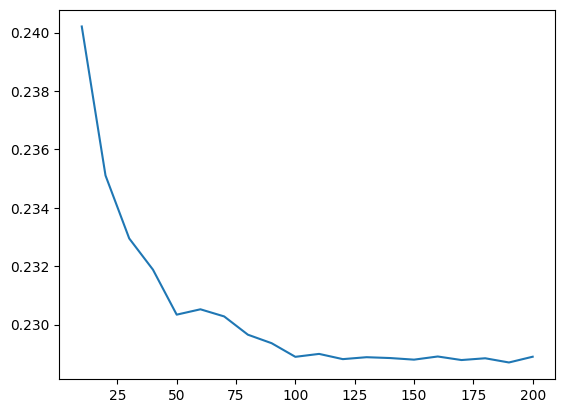

In [40]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

## Question 4
Let's select the best max_depth:

Try different values of max_depth: [10, 15, 20, 25]
For each of these values,
- try different values of n_estimators from 10 till 200 (with step 10)
- calculate the mean RMSE
- Fix the random seed: random_state=1

What's the best max_depth, using the mean RMSE?

In [41]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1,
                                    n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, rmse))

In [42]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

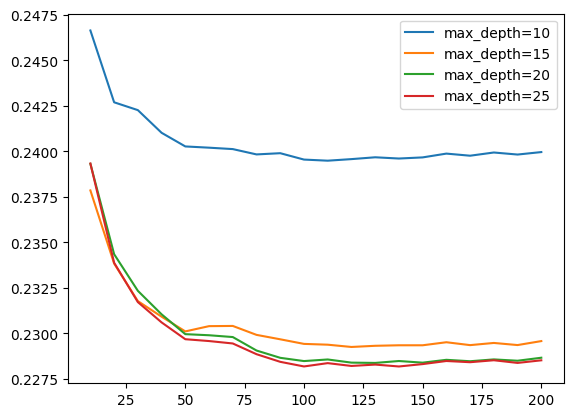

In [43]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

In [45]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    print(f"d = {d}, rmse = {df_subset.rmse.mean()}")

d = 10, rmse = 0.24048765774205422
d = 15, rmse = 0.23040852099278092
d = 20, rmse = 0.2298898241982649
d = 25, rmse = 0.2296667747815698


## Question 5
We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

Train the model with these parameters:
- n_estimators=10,
- max_depth=20,
- random_state=1,
- n_jobs=-1 (optional)

Get the feature importance information from this model

What's the most important feature (among these 4)?

- total_rooms
- median_income
- total_bedrooms
- longitude

In [46]:
rf = RandomForestRegressor(n_estimators=10,
                        max_depth=20,
                        random_state=1,
                        n_jobs=-1)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [49]:
for f,s in zip(list(dv.get_feature_names_out()), rf.feature_importances_):
    print(f"{f} -> {s}")

households -> 0.016028008385119558
housing_median_age -> 0.03229462273706455
latitude -> 0.09966319563775174
longitude -> 0.09173227419069221
median_income -> 0.33472932217427276
ocean_proximity=<1H OCEAN -> 0.25500884786247474
ocean_proximity=INLAND -> 0.11058958417285962
population -> 0.02580074461693287
total_bedrooms -> 0.014180303975825117
total_rooms -> 0.019973096247006862


## Question 6
Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

Install XGBoost

Create DMatrix for train and validation

Create a watchlist

Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```
Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

In [50]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 492.3 kB/s eta 0:00:0000:0100:02


In [51]:
import xgboost as xgb

In [58]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

In [62]:
features = list(dv.get_feature_names_out())
print(f"features origin: {features}")
# Fixes Python's Xgoost: ValueError('feature_names may not contain [, ] or <')
features = ["ocean_proximity=less_1H OCEAN" if f == "ocean_proximity=<1H OCEAN" else f for f in features]
print(f"features transformed: {features}")

features origin: ['households', 'housing_median_age', 'latitude', 'longitude', 'median_income', 'ocean_proximity=<1H OCEAN', 'ocean_proximity=INLAND', 'population', 'total_bedrooms', 'total_rooms']
features transformed: ['households', 'housing_median_age', 'latitude', 'longitude', 'median_income', 'ocean_proximity=less_1H OCEAN', 'ocean_proximity=INLAND', 'population', 'total_bedrooms', 'total_rooms']


In [63]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [65]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [66]:
xgb_params2 = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model2 = xgb.train(xgb_params2, dtrain, num_boost_round=100)

In [67]:
y_pred = model.predict(dval)
y_pred2 = model2.predict(dval)

In [68]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse2 = np.sqrt(mean_squared_error(y_val, y_pred2))
print(f"eta 0.3 => {rmse}, eta 0.1 => {rmse2}")

eta 0.3 => 0.2207210602201332, eta 0.1 => 0.2232794233247614
